In [1]:
# Problem 1
# Starting here is the notebook used for running

import numpy as np
import pandas as pd
import os as os
import glob as glob
import csv as csv

import matplotlib.pyplot as plt

In [15]:
def matrix_factorization(M, U, V, R, steps=5000, t=0.0025, lmbda =0.25):
    
    # M: Rating matrix
    # U: User features
    # V: Movie features
    # R: Feature dimensions
    # steps: Iterations
    # t: Learning rate
    # lmbda: Regularization parameter
    
    # Create Mask P_Omega
    Mask = mask_create(M)
    
    # Create phi_list
    phi_list = []
    
    isConverged = False
    phi_prev = -114514
    abc = True
    
    # Due to excessive calculation required
    # I set up an threshold of 0.1% change below which the phi is considered to be converged
    
    for step in range(steps):
        
        if(step % 500 == 1 and isConverged == False):
            print(step)
        
        if(isConverged == False):
            
            # Gradient Descent Method
            for i in range(len(M)):
                for j in range(len(M[i])):
                    
                    if Mask[i][j] > 0:

                        # Calculate Error here to save calculation
                        e_ij=np.dot(U[i,:],V[:,j])-M[i][j] 

                        for k in range(R):
                            # Gradient Descent
                            U_temp=U[i][k]-t*(2*e_ij*V[k][j]+lmbda*U[i][k])
                            V_temp=V[k][j]-t*(2*e_ij*U[i][k]+lmbda*V[k][j])

                            U[i][k]=U_temp
                            V[k][j]=V_temp
            #Endfor
            
            # Calculate Phi
            # P_Omega is applied by doing Hadamard Product btn Mask and UV-M

            phi = 0.5 * (np.linalg.norm(np.multiply(Mask, (np.matmul(U,V)-M) ))**2)
            phi = phi + lmbda * (np.linalg.norm(U)**2) + lmbda * (np.linalg.norm(V)**2)
            
            
            if(abs((phi-phi_prev)/phi) > 0.00001):
                phi_prev = phi
                phi_list.append(phi_prev)
            else:
                isConverged = True
                
                print("Steps",step,phi,phi_prev,abs((phi-phi_prev)/phi))
                
                phi_prev = phi
                phi_list.append(phi_prev)
            #Endif
            
        else:
            phi_list.append(phi_prev)
    
    #Endfor

    return U, V, phi_list

In [4]:
def mask_create(M):
    
    # Create operator P_omega which I called a "Mask" in this notebook
    
    Mask = np.zeros([len(M), len(M[0])], dtype=int)
    for i in range(len(M)):
        for j in range(len(M[i])):
            if(M[i][j] != 0):
                Mask[i][j] = 1
    #Endfor
    return Mask

In [3]:
def input_converter(users, movies, df):
    
    # Convert input to matrix
    
    M = np.zeros([users, movies])
    for index, row in df.iterrows():
        M[int(row['user_id'])-1][int(row['movie_id'])-1] = row['ratings']
    #Endfor
    return M

In [50]:
def RMSE_M(M_original, M_predicted):
    
    # M_original: M data we collected
    # M_original: M data from our calculation
    
    Mask = mask_create(M_original)
    M_toCompare = np.multiply(Mask, M_predicted)
    
    print("Total Error:", np.linalg.norm(matrix_minus(M_toCompare,M_original)))
    #print("Total Number of", np.linalg.norm(Mask)**2)
    
    return np.linalg.norm(matrix_minus(M_toCompare,M_original)) / np.linalg.norm(Mask)**2

In [12]:
def matrix_minus(A,B):
    
    # Orignially used to make masked deduction in RMSE calculation
    # Idea no longer used, currently just a simple matrix element-wise minus helper
    
    assert len(A) == len(B)
    assert len(A[0]) == len(B[0])
    
    result = np.zeros([len(A),len(A[0])])

    for i in range(len(A)):
        for j in range(len(A[0])):
            result[i][j] = A[i][j] - B[i][j]
    
    return result

In [49]:
def matrix_max_diff(A,B):
    
    # Calculate maximum element-wise difference between predicted & collected data
    
    assert len(A) == len(B)
    assert len(A[0]) == len(B[0])
    
    result = -114514

    for i in range(len(A)):
        for j in range(len(A[0])):
            result = max(result, abs(A[i][j] - B[i][j]))
    
    print("Max diff is", result)

In [10]:
# Save file to local for reuse in other notebooks, for testing
def save_local(identifier):
    if(check_duplicate(identifier) == False):
        for i in range(len(obj_list)):
            write_file("\\" + identifier + str(i) + "Obj.csv",obj_list[i])
            np.save(identifier + str(i) + "M_predicted", M_predicted_list[i])
            np.save(identifier + str(i) + "U", U_list[i])
            np.save(identifier + str(i) + "V", V_list[i])
    else:
        assert check_duplicate(identifier) == False

In [8]:
# Helper for save_local
def write_file(path, lst):
    outfile = open(cwd + path,'a')
    out = csv.writer(outfile)
    out.writerows(map(lambda x: [x], lst))
    outfile.close()

In [9]:
# Helper for save_local
def check_duplicate(identifier):
    
    for file in glob.glob("*.csv"):
        if file == identifier + "0" "Obj.csv":
            return True
    
    return False

In [5]:
# Problem 1
# Initilization Starts Here

'''
WARNING !!!!!!!!!!!!!!!!! RUNNING THIS WILL CLEAR CACHE

'''

# Read Data and Initialize Matrix
# 100,000 ratings (1-5) from 943 users on 1682 movies.
# 95,000 training
# 5,000 test

#Read
cwd = os.getcwd()
df_train = pd.read_csv(cwd + "\\Prob1_ratings.csv", header=None, names=["user_id","movie_id","ratings"])
df_test = pd.read_csv(cwd + "\\Prob1_ratings_test.csv", header=None, names=["user_id","movie_id","ratings"])

# Init
num_users = 943
num_movies = 1682
R = 10

M_train = input_converter(num_users, num_movies , df_train)
M_test = input_converter(num_users, num_movies , df_test)

obj_list = []
M_predicted_list = []
U_list = []
V_list = []

In [23]:
# Run Matrix Factorization

for codeRun in range(0,10):
    
    U = np.random.normal(0,1,(num_users,R))
    V = np.random.normal(0,1,(R,num_movies))
    
    rtnU, rtnV, obj_temp = matrix_factorization(M_train, U, V, R)
    
    obj_list.append(obj_temp)
    M_predicted_list.append(np.dot(rtnU, rtnV))
    U_list.append(rtnU)
    V_list.append(rtnV)

1
501
Steps 987 31646.909575635877 31647.225599825295 9.98594155499102e-06
1
501
1001
Steps 1120 31577.94092463365 31578.2561280381 9.981759266789247e-06
1
501
1001
Steps 1010 31553.007876485655 31553.323125367286 9.991088103690098e-06
1
501
1001
Steps 1127 31572.416591258247 31572.732260952893 9.998274719763006e-06
1
501
1001
Steps 1014 31598.19537376029 31598.510786761137 9.98199413343194e-06
1
501
1001
Steps 1005 31596.283504868064 31596.599129261704 9.989288569034591e-06
1
501
Steps 993 31596.21599994287 31596.53136093903 9.98097354948178e-06
1
501
Steps 996 31587.10738055178 31587.423146573023 9.996674194873823e-06


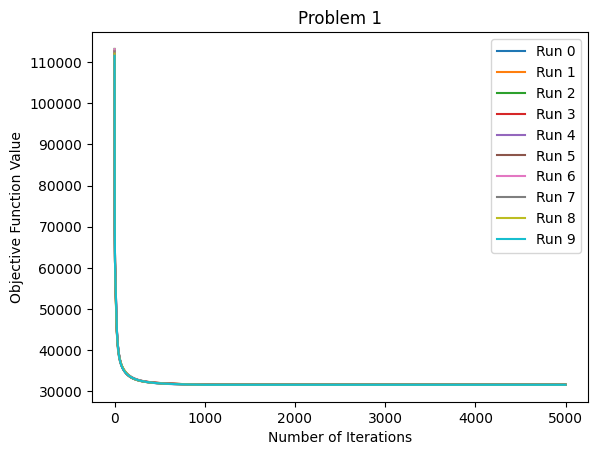

In [155]:
for i in range(2, len(obj_list)):
    plt.plot(obj_list[i],label="Run " + str(i-2))
    
plt.title("Problem 1")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Function Value")
plt.legend()
plt.show()

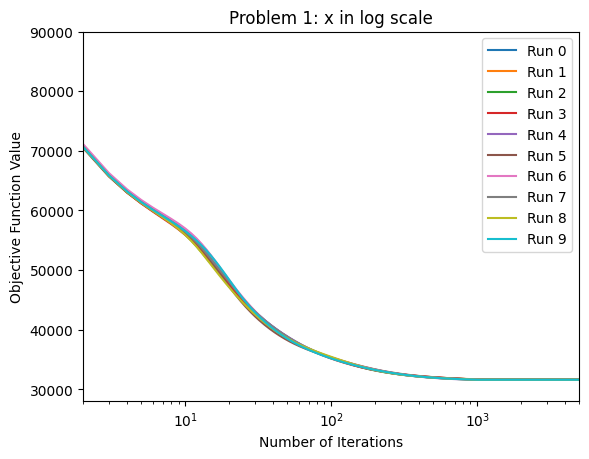

In [156]:
# Note that range starts from 2 as there were two test runs which occupies [0] and [1], below all follows this

for i in range(2, len(obj_list)):
    plt.plot(obj_list[i],label="Run " + str(i-2))
    
plt.title("Problem 1: x in log scale")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Function Value")
plt.xscale("log")
plt.ylim(28000,90000)
plt.xlim(2,5000)
plt.legend()
plt.show()


In [64]:
# Batch calculation for RMSE

RMSE_list = []

for i in range(2, len(obj_list)):
    print("Run ", str(i-2))
    RMSE_temp = RMSE_M(M_test,M_predicted_list[i])
    print(RMSE_temp)
    RMSE_list.append(RMSE_temp)

Run  0
Total Error: 65.44905890205102
0.013089811780410205
Run  1
Total Error: 65.80214004474978
0.013160428008949955
Run  2
Total Error: 65.82481423362155
0.013164962846724311
Run  3
Total Error: 65.31920710560661
0.013063841421121321
Run  4
Total Error: 65.37619017555454
0.013075238035110908
Run  5
Total Error: 65.37209853896124
0.013074419707792249
Run  6
Total Error: 65.63666288202977
0.013127332576405953
Run  7
Total Error: 65.43809510866745
0.01308761902173349
Run  8
Total Error: 65.61579544395826
0.013123159088791652
Run  9
Total Error: 65.36258335744206
0.013072516671488413


In [65]:
# Add last objective function and plot table

converged_obj_function = []
for i in range(2,len(obj_list)):
    converged_obj_function.append(obj_list[i][-1])
#Endfor

tbl = pd.DataFrame({"Objective Function":converged_obj_function,"RMSE":RMSE_list})
tbl.sort_values("Objective Function",ascending=False)

,Objective Function,RMSE
2,31646.909576,0.013165
1,31641.503281,0.013160
0,31621.454908,0.013090
6,31598.195374,0.013127
7,31596.283505,0.013088
8,31596.216000,0.013123
9,31587.107381,0.013073
3,31577.940925,0.013064
5,31572.416591,0.013074
4,31553.007876,0.013075


In [ ]:
# Problem 2

In [85]:
movie_indicies = list(range(0,num_movies))
movie_names = []

In [86]:
f = open("Prob1_movies.txt","r")

for line in f:
    movie_names.append(line.strip())
#Endfor

In [87]:
tbl_movies = pd.DataFrame({"Movie Index":movie_indicies,"Name":movie_names})
print(tbl_movies)

      Movie Index                                       Name
0               0                           Toy Story (1995)
1               1                           GoldenEye (1995)
2               2                          Four Rooms (1995)
3               3                          Get Shorty (1995)
4               4                             Copycat (1995)
...           ...                                        ...
1677         1677                          Mat' i syn (1997)
1678         1678                           B. Monkey (1998)
1679         1679                       Sliding Doors (1998)
1680         1680                        You So Crazy (1994)
1681         1681  Scream of Stone (Schrei aus Stein) (1991)

[1682 rows x 2 columns]


In [94]:
print(tbl_movies.loc[tbl_movies['Name'].str.contains("Star Wars")])
print(tbl_movies.loc[tbl_movies['Name'].str.contains("My Fair Lady")])
print(tbl_movies.loc[tbl_movies['Name'].str.contains("GoodFellas")])

# Search Result:
'''
    Movie Index              Name
49           49  Star Wars (1977)
     Movie Index                 Name
484          484  My Fair Lady (1964)
     Movie Index               Name
181          181  GoodFellas (1990)
'''

    Movie Index              Name
49           49  Star Wars (1977)
     Movie Index                 Name
484          484  My Fair Lady (1964)
     Movie Index               Name
181          181  GoodFellas (1990)


In [113]:
# Run 4 has lowest objective value
# Which transfers to obj_list[6]

# Search Result:
'''
    Movie Index              Name
49           49  Star Wars (1977)
     Movie Index                 Name
484          484  My Fair Lady (1964)
     Movie Index               Name
181          181  GoodFellas (1990)
'''

similar_movies_list = []
distance_list = []

V_Matrix = np.array(V_list[6])
V_matrix = V_Matrix.T

In [112]:
star_war_vector = V_matrix[49]
fair_lad_vector = V_matrix[484]
good_fel_vector = V_matrix[181]

[ 0.43761644  1.05898634 -0.12502944 -0.38881811  0.13551194  0.07801073
 -0.43641462  0.04587287 -0.03451217  0.10959487]


In [131]:
check_list = ["Star Wars (1977)", "My Fair Lady (1964)", "GoodFellas (1990)"]
check_index = [49,484,181]
distance_list_all = []

In [132]:
for i in range(0,3):
    distance_temp_list = []
    for j in range(0,num_movies):
        distance_temp_list.append(np.linalg.norm(V_matrix[check_index[i]] - V_matrix[j]))
    #Endfor
    distance_list_all.append(distance_temp_list)
    

In [134]:
tbl_movies['Star Wars (1977)'] = distance_list_all[0]
tbl_movies['My Fair Lady (1964)'] = distance_list_all[1]
tbl_movies['GoodFellas (1990)'] = distance_list_all[2]

In [149]:
df_temp = tbl_movies.sort_values("Star Wars (1977)",ascending=True)
df_star_war = df_temp[0:11][['Name', 'Star Wars (1977)']]             # Itself + 10 cloeset
df_star_war.rename(columns={'Star Wars (1977)': 'Distance'}, inplace=True)
print(df_star_war)

                                          Name  Distance
49                            Star Wars (1977)  0.000000
171            Empire Strikes Back, The (1980)  0.248505
173             Raiders of the Lost Ark (1981)  0.358180
172                 Princess Bride, The (1987)  0.516845
180                  Return of the Jedi (1983)  0.566875
11                  Usual Suspects, The (1995)  0.734865
209  Indiana Jones and the Last Crusade (1989)  0.758822
193                          Sting, The (1973)  0.768163
301                   L.A. Confidential (1997)  0.768524
519                   Great Escape, The (1963)  0.786807
95           Terminator 2: Judgment Day (1991)  0.792287


In [150]:
df_temp = tbl_movies.sort_values('My Fair Lady (1964)',ascending=True)
df_fair_ldy = df_temp[0:11][['Name', 'My Fair Lady (1964)']]             # Itself + 10 cloeset
df_fair_ldy.rename(columns={'My Fair Lady (1964)': 'Distance'}, inplace=True)
print(df_fair_ldy)

                                Name  Distance
484              My Fair Lady (1964)  0.000000
485                   Sabrina (1954)  0.465578
418              Mary Poppins (1964)  0.545976
587      Beauty and the Beast (1991)  0.556490
958        Dazed and Confused (1993)  0.590211
142       Sound of Music, The (1965)  0.599565
282                      Emma (1996)  0.601937
215   When Harry Met Sally... (1989)  0.610156
1285          Shall We Dance? (1937)  0.624500
303             Fly Away Home (1996)  0.632423
132        Gone with the Wind (1939)  0.654929


In [151]:
df_temp = tbl_movies.sort_values('GoodFellas (1990)',ascending=True)
df_good_fel = df_temp[0:11][['Name', 'GoodFellas (1990)']]             # Itself + 10 cloeset
df_good_fel.rename(columns={'GoodFellas (1990)': 'Distance'}, inplace=True)
print(df_good_fel)

                                       Name  Distance
181                       GoodFellas (1990)  0.000000
503                 Bonnie and Clyde (1967)  0.397596
176  Good, The Bad and The Ugly, The (1966)  0.405351
645     Once Upon a Time in the West (1969)  0.412459
692                           Casino (1995)  0.431626
187                Full Metal Jacket (1987)  0.444382
199                     Shining, The (1980)  0.467131
179                   Apocalypse Now (1979)  0.487876
522                   Cool Hand Luke (1967)  0.501865
134            2001: A Space Odyssey (1968)  0.506247
184                           Psycho (1960)  0.518744
